In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%load_ext tensorboard
import os

if not os.path.isdir('./HypernetworkSiren'):
  !git clone https://github.com/ZrbTz/HypernetworkSiren.git
  !bash -c 'mv ./HypernetworkSiren/* ./'

In [ ]:
from hypersiren import *
print_CUDA_memory_statistics()

#put this to true if you want to resume a previous training
restore = False

# SUPER RESOLUTION TEST
datasetTrainingPath = "/content/images/DIV2K_train_HR"
datasetValidationPath = "/content/images/DIV2K_valid_HR"
datasetTestPath = "/content/images/Set14/" #test is done only on lenna.png
epochs = 1000 #1000
steps_til_summary = 100
max_num_images = 800 #800
max_val_images = 100 #100
max_test_images = 14
batch_size = 25 #25
hidden_features = 128 #128
better_params = (30, 30, 2e-5, 0.1)
lambda_latent = 1e-1
lambda_weights = 1e2
lambda_biases = 1e2
width_LR = 64
height_LR = 64
factor = 4
width_HR = width_LR * factor
height_HR = height_LR * factor

checkpoint_path = "/content/drive/MyDrive/backup_training/hyper_init2_SIREN_PRIOR_BRANCH_REG_DA_ep" + str(epochs) + "_im" + str(max_num_images) + ".chk"
writer_folder = "/content/drive/MyDrive/backup_training/hyper_init2_SIREN_PRIOR_BRANCH_REG_DA_ep" + str(epochs) + "_im" + str(max_num_images)


CUDA-0 used memory [0 bytes / 17071734784 bytes (0.00%)]


In [ ]:
def deep_prior(net, input_grid_LR, input_grid_HR, ground_truth_HR, ground_truth_LR, original_ground_truth_LR, lr=3e-4, gamma=0.1, step = 0, total_steps = 500,
                steps_til_summary = 5, width_HR = 256, height_HR = 256, lambda_latent = 0, lambda_weights = 0, lambda_biases = 0):
  #define optimizer

  original_ground_truth_LR.cuda(), input_grid_LR.cuda(), input_grid_HR.cuda(), ground_truth_HR.cuda(), ground_truth_LR.cuda()

  params_to_optimize = net.parameters()
  optimizer = torch.optim.Adam(lr=lr, params=params_to_optimize, weight_decay=0.0005)
  scheduler= torch.optim.lr_scheduler.StepLR(optimizer, total_steps*3//4, gamma=gamma)
 
  estimator = Time_estimator(total_steps, steps_til_summary)
  loss = 0

  while step < total_steps:
      psnrs_t = []
      
      output_image_LR, coords_LR, weights, bias, latent_space = net(original_ground_truth_LR, input_grid_LR) #forward pass 
 
      loss = ((output_image_LR - ground_truth_LR)**2).mean()   #calculate loss on image (MSE)
      loss += lambda_latent * ((latent_space)**2).mean()  #loss on latent space (enforces a Gaussian prior on latent code)
      loss += lambda_weights * ((weights)**2).mean()   #loss on weights (encourage a lower frequency representation of the image)
      loss += lambda_biases * ((bias)**2).mean()

      input_grid_HR.cpu(), ground_truth_HR.cpu(), ground_truth_LR.cpu(), output_image_LR.cpu(), coords_LR.cpu(), original_ground_truth_LR.cpu(), input_grid_LR.cpu()

      optimizer.zero_grad() #Sets the gradients of all optimized torch.Tensor to zero
      loss.backward() #apply gradients
      optimizer.step()  #make optimizer step
      
      scheduler.step()
      step = step + 1

  del input_grid_HR
  del ground_truth_HR
  del ground_truth_LR
  del output_image_LR
  del coords_LR
  del original_ground_truth_LR

In [ ]:
training_dataloader = DataLoader(Hyper_ImageFitting_RGB_DA(datasetTrainingPath, width_LR, height_LR, factor, max = max_num_images, apply_random_transforms=True), batch_size=batch_size, pin_memory=True, num_workers=0, shuffle=True)
validation_dataloader = DataLoader(Hyper_ImageFitting_RGB_DA(datasetValidationPath, width_LR, height_LR, factor, max = max_val_images), batch_size=10, pin_memory=True, num_workers=0, shuffle=True)

hyper_siren = Hyp_Siren(in_features=2, out_features=3, hidden_features=hidden_features, hidden_layers=3, hypernetInit=HyperMetaAlexNet.hyperMetaAlexNet,
                        first_omega_0=better_params[0], hidden_omega_0=better_params[1])

hyper_siren.cuda()

print_CUDA_memory_statistics()

writer = SummaryWriter(writer_folder)

prior_train(hyper_siren, training_dataloader, validation_dataloader, writer,
            lr = better_params[2], gamma = better_params[3], width_HR = width_HR,
            height_HR = height_HR, total_steps = epochs, 
            steps_til_summary = steps_til_summary, lambda_latent = lambda_latent,
            lambda_weights = lambda_weights, lambda_biases = lambda_biases, 
            restore = restore, checkpoint_path = checkpoint_path)

writer.flush()

print_CUDA_memory_statistics()

CUDA-0 used memory [474228736 bytes / 17071734784 bytes (2.78%)]
=> loading checkpoint '/content/drive/MyDrive/backup_training/hyper_init2_SIREN_PRIOR_BRANCH_REG_DA_ep1000_im800.chk'
=> loaded checkpoint '/content/drive/MyDrive/backup_training/hyper_init2_SIREN_PRIOR_BRANCH_REG_DA_ep1000_im800.chk' (epoch 1000)
CUDA-0 used memory [474228736 bytes / 17071734784 bytes (2.78%)]


CUDA-0 used memory [3316316672 bytes / 17071734784 bytes (19.43%)]
[image 1/14 - 7.14%]
Running on GPU 0


./srgan/models/weight_inits.py:101: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  _get_init_fn(weight_init)(m.weight.data)
./srgan/models/weight_inits.py:103: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  _get_init_fn(bias_init)(m.bias.data)
./srgan/models/weight_inits.py:101: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  _get_init_fn(weight_init)(m.weight.data)


Restored checkpoint from srgan/resources/pretrained/srgan.pth


./srgan/training/base_runner.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = [Variable(tensor, volatile=volatile) for tensor in batch]


Running on GPU 0
Restored checkpoint from srgan/resources/pretrained/srresnet.pth


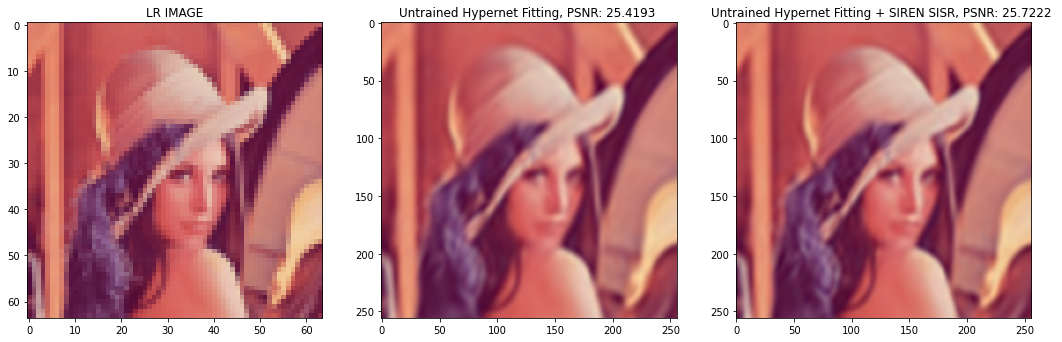

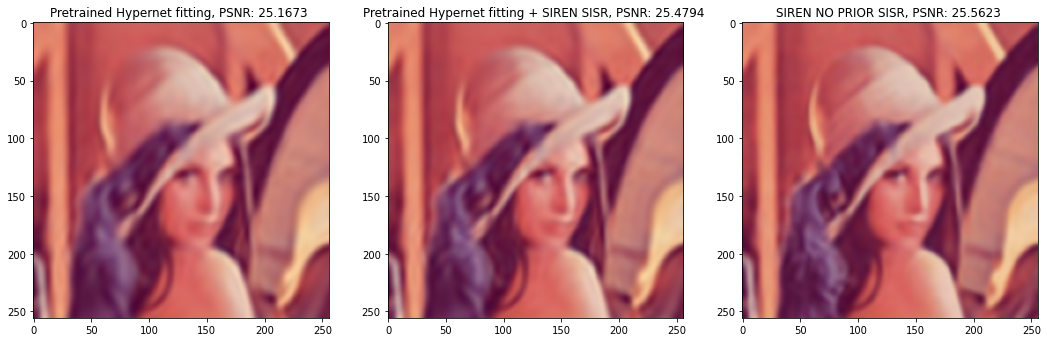

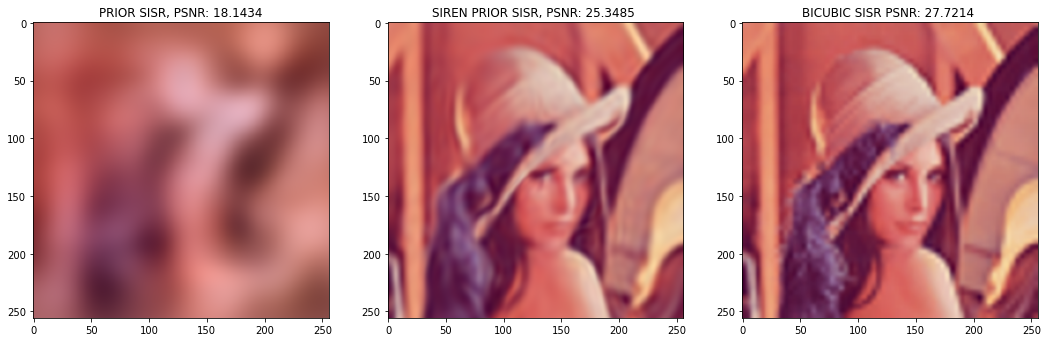

Estimated time: 0:5:34 / 1:18:6


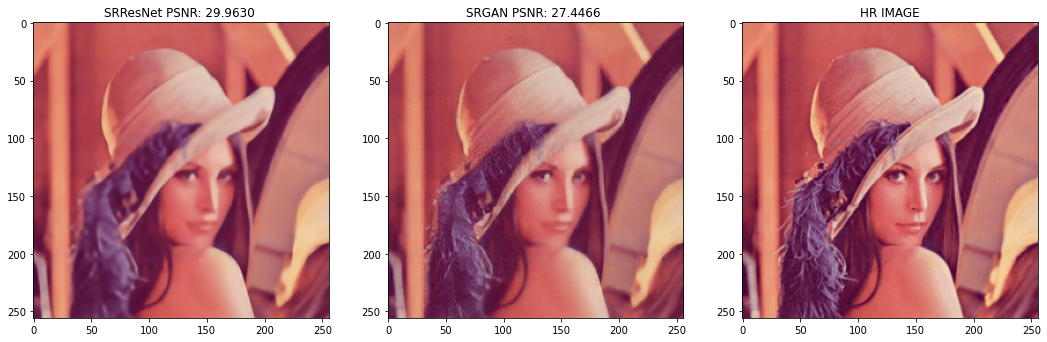

CUDA-0 used memory [4267416064 bytes / 17071734784 bytes (25.00%)]


In [ ]:
import copy
print_CUDA_memory_statistics()
max_test_images = 14

test_dataloader = DataLoader(TestImageFitting_RGB(datasetTestPath, width_LR, height_LR, factor, max = max_test_images), batch_size=1, pin_memory=True, num_workers=0, shuffle=False)
estimator = Time_estimator(total_steps = max_test_images, steps_til_summary = 1)

iter = 0
for input_grid_LR, input_grid_HR, ground_truth_HR, ground_truth_LR, original_ground_truth_LR, filename in test_dataloader:
  if filename[0] == "/content/images/Set14//lenna.png":
      iter += 1
      input_grid_LR = input_grid_LR.cuda()
      input_grid_HR = input_grid_HR.cuda()
      ground_truth_HR = ground_truth_HR.cuda()
      ground_truth_LR = ground_truth_LR.cuda()
      original_ground_truth_LR = original_ground_truth_LR.cuda()

      output_prior_image, _, weight_prior, bias_prior, _ = hyper_siren(original_ground_truth_LR, input_grid_HR)
      
      hyper_siren2 = copy.deepcopy(hyper_siren)
  
      deep_prior(hyper_siren2, input_grid_LR, input_grid_HR, ground_truth_HR, ground_truth_LR, original_ground_truth_LR,
              lr = better_params[2], gamma = better_params[3], width_HR = width_HR,
              height_HR = height_HR, total_steps = 5000, 
              steps_til_summary = steps_til_summary, lambda_latent = 1e-1,
              lambda_weights = 1e2, lambda_biases = 1e2)
      
      hyper_siren3 = Hyp_Siren(in_features=2, out_features=3, hidden_features=hidden_features, hidden_layers=3, hypernetInit=HyperMetaAlexNet.hyperMetaAlexNet,
                          first_omega_0=better_params[0], hidden_omega_0=better_params[1])
      
      hyper_siren3.cuda()
      
      
      deep_prior(hyper_siren3, input_grid_LR, input_grid_HR, ground_truth_HR, ground_truth_LR, original_ground_truth_LR,
              lr = better_params[2], gamma = better_params[3], width_HR = width_HR,
              height_HR = height_HR, total_steps = 5000, 
              steps_til_summary = steps_til_summary, lambda_latent = 1e-1,
              lambda_weights = 1e2, lambda_biases = 1e2)
      
      
      output_prior_image2, _, weight_prior2, bias_prior2, _ = hyper_siren2(original_ground_truth_LR, input_grid_HR)

      output_prior_image3, _, weight_prior3, bias_prior3, _ = hyper_siren3(original_ground_truth_LR, input_grid_HR)

      #SIREN TRAIN WITH PRIOR --------------------------------------------------------
      img_siren = Basic_Siren(in_features=2, out_features=3, hidden_features=hidden_features, hidden_layers=3, first_omega_0=30, hidden_omega_0=30, w = weight_prior, b = bias_prior)
      img_siren.cuda()
      train(img_siren, input_grid_LR, ground_truth_LR, name = os.path.basename(filename[0]) + "/test_prior", writer = writer, lr = 0.0001, gamma = 0.1, width = width_LR, height = height_LR)

      siren_output_HR_prior, _ = img_siren(input_grid_HR)

      #SIREN TRAIN WITHOUT PRIOR -----------------------------------------------------
      img_siren = Basic_Siren(in_features=2, out_features=3, hidden_features=hidden_features, hidden_layers=3, first_omega_0=30, hidden_omega_0=30)
      img_siren.cuda()
      train(img_siren, input_grid_LR, ground_truth_LR, name = os.path.basename(filename[0]) + "/test_no_prior", writer = writer, lr = 0.0001, gamma = 0.1, width = width_LR, height = height_LR)

      siren_output_HR_no_prior, _ = img_siren(input_grid_HR)

      #SIREN TRAIN deep image prior no prior --------------------------------------------------------
      img_siren = Basic_Siren(in_features=2, out_features=3, hidden_features=hidden_features, hidden_layers=3, first_omega_0=30, hidden_omega_0=30, w = weight_prior3, b = bias_prior3)
      img_siren.cuda()
      train(img_siren, input_grid_LR, ground_truth_LR, name = os.path.basename(filename[0]) + "/test_new", writer = writer, lr = 0.0001, gamma = 0.1, width = width_LR, height = height_LR)

      siren_output_HR_prior3, _ = img_siren(input_grid_HR)

      #SIREN TRAIN deep image prior & prior --------------------------------------------------------
      img_siren = Basic_Siren(in_features=2, out_features=3, hidden_features=hidden_features, hidden_layers=3, first_omega_0=30, hidden_omega_0=30, w = weight_prior2, b = bias_prior2)
      img_siren.cuda()
      train(img_siren, input_grid_LR, ground_truth_LR, name = os.path.basename(filename[0]) + "/test_new", writer = writer, lr = 0.0001, gamma = 0.1, width = width_LR, height = height_LR)

      siren_output_HR_prior2, _ = img_siren(input_grid_HR)
      
      print("[image {}/{} - {:.2%}]".format(iter, max_test_images, iter/max_test_images))

      # computing PSNR PRIOR
      psnr_prior = psnr(target = ground_truth_HR, input = output_prior_image)

      #computing PSNR deep image prior siren
      psnr_prior2 = psnr(target = ground_truth_HR, input = output_prior_image2)

      # computing PSNR deep image prior no siren
      psnr_prior3 = psnr(target = ground_truth_HR, input = output_prior_image3)

      # computing PSNR SIREN with prior
      psnr_siren_prior = psnr(target = ground_truth_HR, input = siren_output_HR_prior)

      # computing PSNR SIREN with no prior
      psnr_siren_no_prior = psnr(target = ground_truth_HR, input = siren_output_HR_no_prior)

      # computing PSNR SIREN new
      psnr_siren3 = psnr(target = ground_truth_HR, input = siren_output_HR_prior3)

      # computing PSNR SIREN with deep image prior and prior
      psnr_siren2 = psnr(target = ground_truth_HR, input = siren_output_HR_prior2)
      
      # computing PSNR BICUBIC
      bicubic_output = get_bicubic_image(filename[0], width_LR, height_LR, width_HR, height_HR).permute(1, 2, 0).view(-1, 3)
      bicubic_output = bicubic_output.cuda()
      psnr_bicubic = psnr(target = ground_truth_HR, input = bicubic_output)

      # Save temp image for SRGAN and SRResNet
      save_image(ground_truth_LR.squeeze().view(height_LR, width_LR, 3).permute(2, 0, 1), 'srgan/pred/tmp.png', nrow=4)

      # computing PSNR SRGAN
      srgan = getSRGAN('srgan/pred/tmp.png', height_HR, width_HR)
      srgan = srgan.cuda()
      psnr_srgan = psnr(target = ground_truth_HR, input = srgan)

      # computing PSNR SRResNet
      srresnet = getSRRESNET('srgan/pred/tmp.png', height_HR, width_HR)
      srresnet = srresnet.cuda()
      psnr_srresnet = psnr(target = ground_truth_HR, input = srresnet)


      # PLOT result
      #Untrained means no pretrain on DIV2K
      fig, axes = plt.subplots(1,3, figsize=(18,10))
      axes[0].set_title("LR IMAGE")
      axes[0].imshow(ground_truth_LR.cpu().view(height_LR, width_LR, 3).detach().numpy())
      axes[1].set_title("Untrained Hypernet Fitting, PSNR: %0.4f " % psnr_prior3)
      axes[1].imshow(torch.clamp(output_prior_image3.cpu(), min=0, max=1).view(height_HR, width_HR, 3).detach().numpy())
      axes[2].set_title("Untrained Hypernet Fitting + SIREN SISR, PSNR: %0.4f " % psnr_siren3)
      axes[2].imshow(torch.clamp(siren_output_HR_prior3.cpu(), min=0, max=1).view(height_HR, width_HR, 3).detach().numpy())

      plt.show()

      fig, axes = plt.subplots(1,3, figsize=(18,10))
      axes[0].set_title("Pretrained Hypernet fitting, PSNR: %0.4f " % psnr_prior2)
      axes[0].imshow(torch.clamp(output_prior_image2.cpu(), min=0, max=1).view(height_HR, width_HR, 3).detach().numpy())
      axes[1].set_title("Pretrained Hypernet fitting + SIREN SISR, PSNR: %0.4f " % psnr_siren2)
      axes[1].imshow(torch.clamp(siren_output_HR_prior2.cpu(), min=0, max=1).view(height_HR, width_HR, 3).detach().numpy())
      axes[2].set_title("SIREN NO PRIOR SISR, PSNR: %0.4f " % psnr_siren_no_prior)
      axes[2].imshow(torch.clamp(siren_output_HR_no_prior.cpu(), min=0, max=1).view(height_HR, width_HR, 3).detach().numpy())

      plt.show()

      fig, axes = plt.subplots(1,3, figsize=(18,10))
      axes[0].set_title("PRIOR SISR, PSNR: %0.4f" %psnr_prior)
      axes[0].imshow(torch.clamp(output_prior_image.cpu(), min=0, max=1).view(height_HR, width_HR, 3).detach().numpy())
      axes[1].set_title("SIREN PRIOR SISR, PSNR: %0.4f " % psnr_siren_prior)
      axes[1].imshow(torch.clamp(siren_output_HR_prior.cpu(), min=0, max=1).view(height_HR, width_HR, 3).detach().numpy())
      axes[2].set_title("BICUBIC SISR PSNR: %0.4f " % psnr_bicubic)
      axes[2].imshow(bicubic_output.cpu().view(height_HR, width_HR,3).detach().numpy())


      plt.show()
      fig, axes = plt.subplots(1,3, figsize=(18,10))
      axes[0].set_title("SRResNet PSNR: %0.4f " % psnr_srresnet)
      axes[0].imshow(srresnet.cpu().view(height_HR, width_HR,3).detach().numpy())
      axes[1].set_title("SRGAN PSNR: %0.4f " % psnr_srgan)
      axes[1].imshow(srgan.cpu().view(height_HR, width_HR,3).detach().numpy())
      axes[2].set_title("HR IMAGE")
      axes[2].imshow(ground_truth_HR.cpu().view(height_HR, width_HR,3).detach().numpy())

      estimator.checkpoint(iter)

      plt.show()

      print_CUDA_memory_statistics()

      hyper_siren2 = hyper_siren2.cpu()
      del hyper_siren2

      hyper_siren3 = hyper_siren3.cpu()
      del hyper_siren3